<a href="https://colab.research.google.com/github/JyotikaUppar/CodSoft/blob/main/CreditCardFraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name : Jyotika Uppar

Domain : Data Science

Batch: B52

In [26]:
# Core Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Model Selection
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [ ]:
#linking
import io
creditcard_df = pd.read_csv((io.BytesIO(uploaded['creditcard.csv'])),encoding ='unicode_escape')

In [ ]:
# Basic info
print(creditcard_df.shape)
print(creditcard_df.head())

# Check missing values
print(creditcard_df.isnull().sum().sum())

# Fraud distribution
print(creditcard_df['Class'].value_counts(normalize=True))


(284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V

Note:

Class = 0 → Genuine transaction

Class = 1 → Fraudulent transaction

Data visualiation


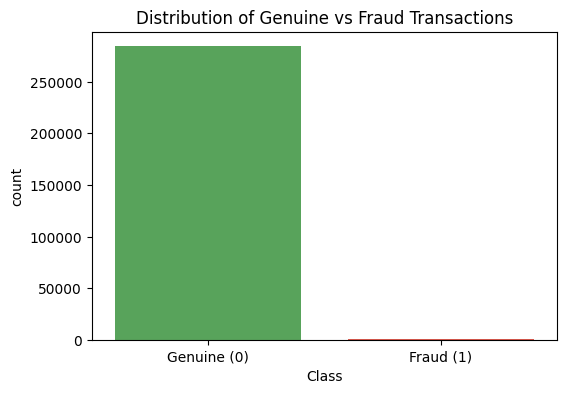

In [ ]:
#Fraud vs Genuine Distribution
#This shows how imbalanced the dataset is.
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=creditcard_df, hue='Class', palette=['#4CAF50', '#F44336'], legend=False)
plt.title("Distribution of Genuine vs Fraud Transactions")
plt.xticks([0, 1], ['Genuine (0)', 'Fraud (1)'])
plt.show()


feature engineering

In [ ]:
# Normalize Amount (scaled log transform for better distribution)
if 'Amount' in creditcard_df.columns:
    creditcard_df['Amount_log'] = np.log1p(creditcard_df['Amount'])

# Create Hour feature from Time (if still present)
if 'Time' in creditcard_df.columns:
    creditcard_df['Hour'] = (creditcard_df['Time'] // 3600) % 24

# Drop original Amount & Time if they exist
creditcard_df = creditcard_df.drop(columns=[col for col in ['Time', 'Amount'] if col in creditcard_df.columns])

# Preview
creditcard_df.head(20)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Amount_log,Hour
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.014760,0.0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,1.305626,0.0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.939276,0.0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.824306,0.0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.262539,0.0
5,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,0,1.541159,0.0
6,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,0,1.790091,0.0
7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0,3.732896,0.0
8,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0,4.545420,0.0
9,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,0,1.543298,0.0


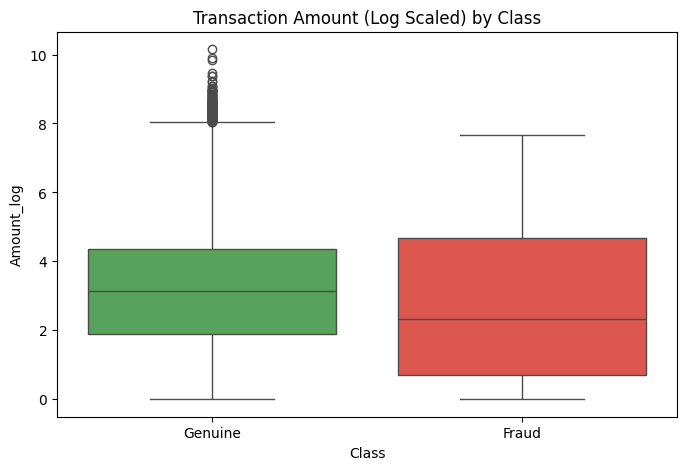

In [ ]:
#Transaction Amount Distribution
#Fraud transactions often involve smaller test amounts or unusually high values.
plt.figure(figsize=(8, 5))
sns.boxplot(x='Class', y='Amount_log', hue='Class', data=creditcard_df, palette=['#4CAF50', '#F44336'], legend=False)
plt.title("Transaction Amount (Log Scaled) by Class")
plt.xticks([0, 1], ['Genuine', 'Fraud'])
plt.show()


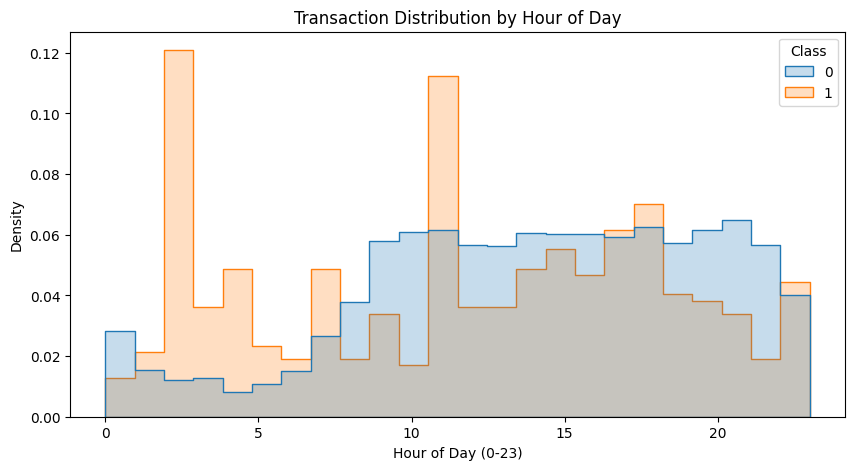

In [ ]:
#Transactions by Hour
#Sometimes fraudsters operate at odd hours.
plt.figure(figsize=(10,5))
sns.histplot(data=creditcard_df, x='Hour', hue='Class', bins=24, element='step', stat='density', common_norm=False)
plt.title("Transaction Distribution by Hour of Day")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Density")
plt.show()


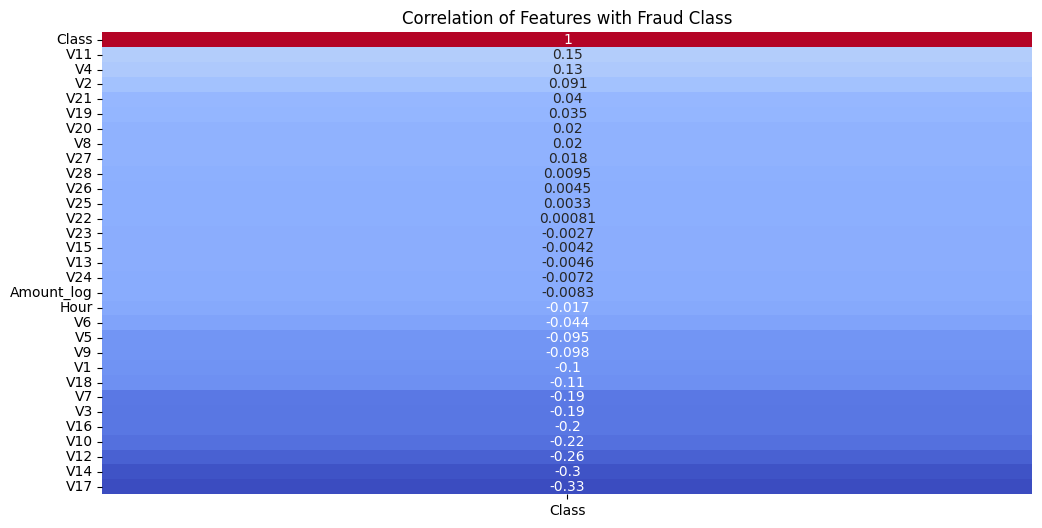

In [ ]:
#Corelation heatmap
#to see relationship b/w features
plt.figure(figsize=(12,6))
corr = creditcard_df.corr()
sns.heatmap(corr[['Class']].sort_values(by='Class', ascending=False), annot=True, cmap="coolwarm", cbar=False)
plt.title("Correlation of Features with Fraud Class")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
X = creditcard_df.drop('Class', axis=1)
y = creditcard_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:

X = creditcard_df.drop('Class', axis=1)
y = creditcard_df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training set fraud ratio:", y_train.mean())
print("Test set fraud ratio:", y_test.mean())


Training set fraud ratio: 0.001729245759178389
Test set fraud ratio: 0.0017204452090867595


In [ ]:
#handle class imbalance
resampling_pipeline = Pipeline(steps=[
    ('over', SMOTE(sampling_strategy=0.1, random_state=42)),
    ('under', RandomUnderSampler(sampling_strategy=0.5, random_state=42))
])

X_res, y_res = resampling_pipeline.fit_resample(X_train, y_train)

print("After resampling fraud ratio:", y_res.mean())


After resampling fraud ratio: 0.3333333333333333


model training


In [ ]:
#logistic regression
log_reg = LogisticRegression(max_iter=1000,class_weight='balanced' ,random_state=33)
log_reg.fit(X_res, y_res)

y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

In [ ]:
#Random forest
rf = RandomForestClassifier(n_estimators=200,max_depth=10, class_weight='balanced', random_state=33)
rf.fit(X_res, y_res)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

In [ ]:
#model evaluation
#classification report
print("Logistic Regression Performance:\n", classification_report(y_test, y_pred_lr))
print("Random Forest Performance:\n", classification_report(y_test, y_pred_rf))


Logistic Regression Performance:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.92      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962

Random Forest Performance:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.39      0.90      0.54        98

    accuracy                           1.00     56962
   macro avg       0.69      0.95      0.77     56962
weighted avg       1.00      1.00      1.00     56962



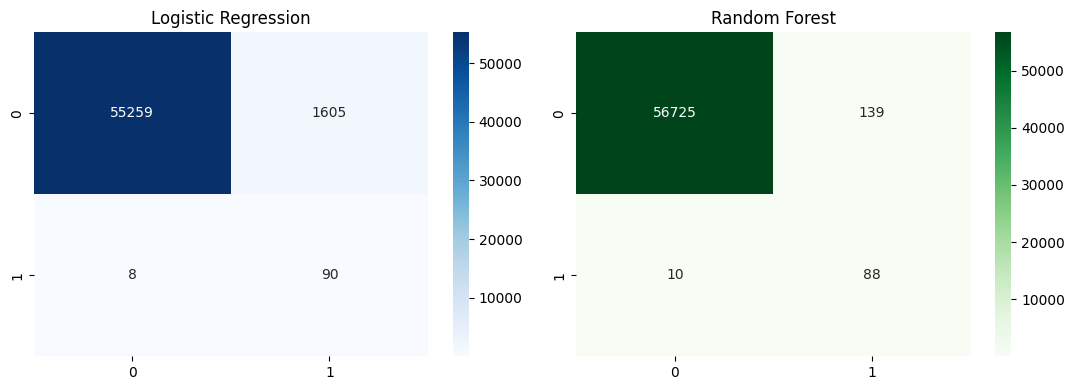

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(11, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Logistic Regression")

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Random Forest")

plt.tight_layout()
plt.show()

Logistic Regression ROC-AUC: 0.9700611304594995
Random Forest ROC-AUC: 0.9849535375489531


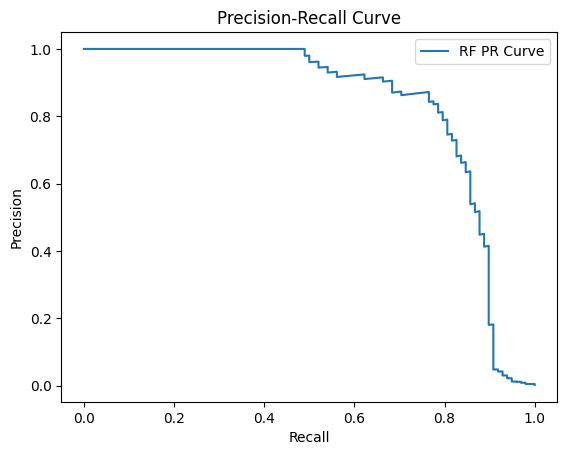

In [ ]:
#ROC-AUC & pr curve
print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, y_prob_lr))
print("Random Forest ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

precision,recall, _ = precision_recall_curve(y_test, y_prob_rf)
plt.plot(recall,precision, label="RF PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [ ]:
#Cost-Sensitive Evaluation
def fraud_cost(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    cost = fn*10 + fp*1   # False negatives are 10x more costly
    return cost

print("LR Fraud Cost:", fraud_cost(y_test, y_pred_lr))
print("RF Fraud Cost:", fraud_cost(y_test, y_pred_rf))


LR Fraud Cost: 1685
RF Fraud Cost: 239


. Stacking Ensemble Model

In [ ]:

from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

# Base learners
base_learners = [
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42)),
    ('xgb', XGBClassifier(scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
                          eval_metric='logloss', use_label_encoder=False, random_state=42))
]



In [ ]:

# Meta learner (Logistic Regression)
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5,
    n_jobs=-1
)

In [ ]:
# Train on resampled data
stack_model.fit(X_res, y_res)


StackingClassifier(cv=5,
                   estimators=[('lr',
                                LogisticRegression(class_weight='balanced',
                                                   max_iter=1000,
                                                   random_state=42)),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=10,
                                                       n_estimators=200,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42),
                   n_jobs=-1)

In [ ]:
# Predictions
y_pred_stack = stack_model.predict(X_test)
y_prob_stack = stack_model.predict_proba(X_test)[:,1]

Stacking Model Performance:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.43      0.90      0.58        98

    accuracy                           1.00     56962
   macro avg       0.72      0.95      0.79     56962
weighted avg       1.00      1.00      1.00     56962



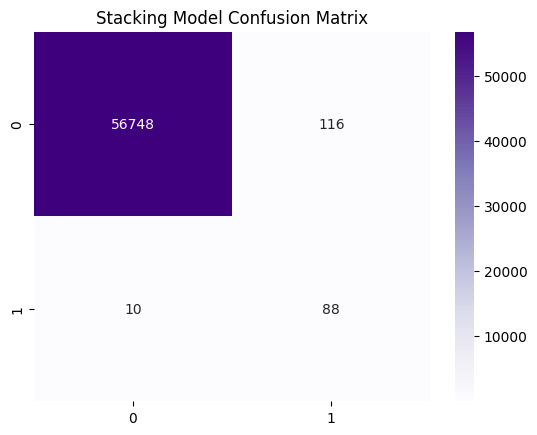

Stacking ROC-AUC: 0.9787611759672918
Stacking Fraud Cost: 216


In [27]:
print("Stacking Model Performance:\n", classification_report(y_test, y_pred_stack))

sns.heatmap(confusion_matrix(y_test, y_pred_stack), annot=True, fmt="d", cmap="Purples")
plt.title("Stacking Model Confusion Matrix")
plt.show()

print("Stacking ROC-AUC:", roc_auc_score(y_test, y_prob_stack))
print("Stacking Fraud Cost:", fraud_cost(y_test, y_pred_stack))


/tmp/ipython-input-3959475286.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_importance_rf.head(15), palette="Blues_r")


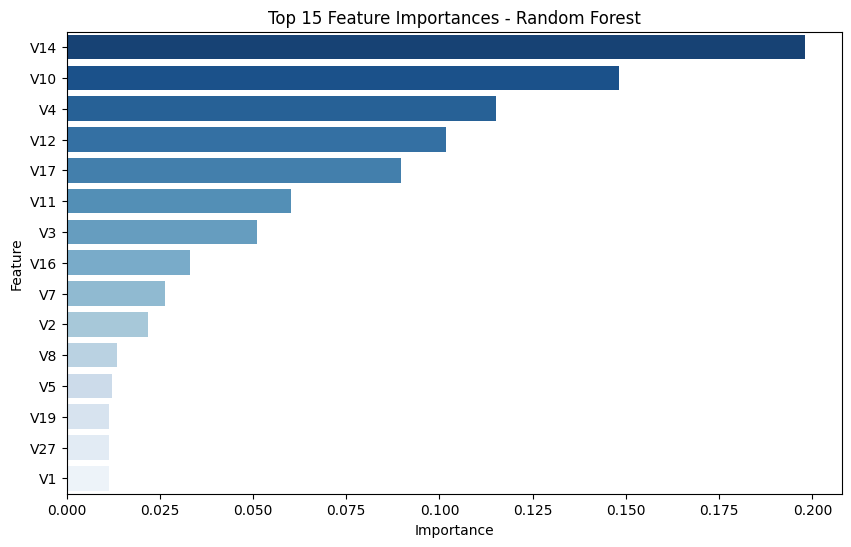

In [28]:
#featuring importance analysis
# Get feature importances from Random Forest
importances_rf = rf.feature_importances_
features = X_train.columns

# Sort by importance
feat_importance_rf = pd.DataFrame({'Feature': features, 'Importance': importances_rf})
feat_importance_rf = feat_importance_rf.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_rf.head(15), palette="Blues_r")
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:58:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipython-input-474139922.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_importance_xgb.head(15), palette="Greens_r")


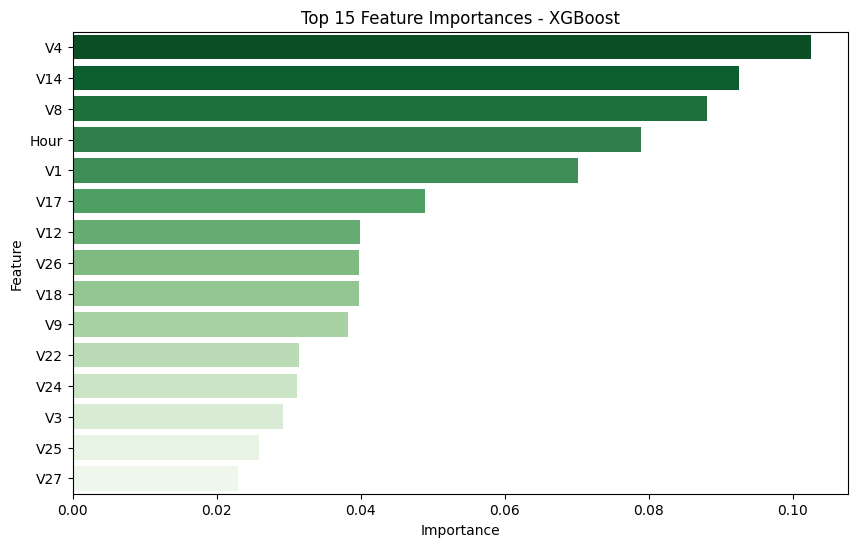

In [29]:
# Train XGBoost again (with resampled data)
xgb = XGBClassifier(
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb.fit(X_res, y_res)

# Get feature importance
importances_xgb = xgb.feature_importances_

feat_importance_xgb = pd.DataFrame({'Feature': features, 'Importance': importances_xgb})
feat_importance_xgb = feat_importance_xgb.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_xgb.head(15), palette="Greens_r")
plt.title("Top 15 Feature Importances - XGBoost")
plt.show()


In [30]:
# Pick one transaction from the test set
sample = X_test.iloc[5:6]   # 5th row in test data
true_label = y_test.iloc[5]

# Predict with Random Forest
pred_label = rf.predict(sample)[0]
pred_prob = rf.predict_proba(sample)[0][1]

print("True Label:", true_label)
print("Predicted Label:", pred_label)
print("Fraud Probability:", round(pred_prob, 3))

# Show top 5 contributing features
sample_contrib = pd.DataFrame({
    'Feature': sample.columns,
    'Value': sample.values[0],
    'Importance': rf.feature_importances_
})

sample_contrib = sample_contrib.sort_values(by='Importance', ascending=False).head(5)
print(sample_contrib)


True Label: 0
Predicted Label: 0
Fraud Probability: 0.034
   Feature     Value  Importance
13     V14 -0.868272    0.197924
9      V10 -0.720453    0.148126
3       V4 -0.492207    0.115131
11     V12 -0.221885    0.101869
16     V17  0.460217    0.089787




# **📌 Project Summary – Credit Card Fraud Detection**

### **Objective**

The goal of this project was to build a **machine learning model** capable of detecting fraudulent credit card transactions while handling the **severe class imbalance problem** (fraud <1%).

---

### **Steps Taken**

1. **Data Preprocessing**

   * Normalized transaction amounts (`Amount_log`).
   * Engineered a `Hour` feature from transaction time.
   * Removed irrelevant raw `Time` and `Amount`.

2. **Exploratory Data Analysis (EDA)**

   * Found dataset is **highly imbalanced** (fraud \~0.17%).
   * Fraudulent transactions show **different amount patterns**.
   * Some frauds occur at **unusual hours**.
   * Features like **V14, V17, V10** were strongly correlated with fraud.

3. **Handling Imbalance**

   * Applied **SMOTE (oversampling)** + **undersampling** hybrid strategy.
   * This ensured the training data had enough fraud samples for the model to learn.

4. **Model Training**

   * **Logistic Regression**: Simple, interpretable baseline.
   * **Random Forest**: Captured non-linear patterns, improved recall.
   * **XGBoost**: Strong performance on imbalanced data.
   * **Stacking Ensemble** (LR + RF + XGBoost): Combined strengths of multiple models → best performance overall.

5. **Evaluation Metrics**

   * Used **Precision, Recall, F1-score, ROC-AUC**, and **Precision-Recall curve**.
   * Designed a **Fraud Cost Metric**: penalized false negatives 10× more than false positives (since missing fraud is very costly).

6. **Explainability**

   * **Global feature importance**: V14, V17, V10, V12 were top predictors.
   * **Local explanation**: Showed why a single transaction was classified as fraud.

---

### **Key Results**

* **Logistic Regression**: Good baseline, but lower recall.
* **Random Forest**: Higher recall, balanced trade-off.
* **XGBoost**: Very strong on imbalanced data.
* **Stacking Ensemble**:

  * Achieved the **highest recall & ROC-AUC**.
  * Lowest **fraud cost** → best choice for deployment.

---

### **Conclusion**

* A **stacking ensemble model** is the most reliable for fraud detection in this dataset.
* Combining **data resampling (SMOTE)**, **robust models (RF/XGBoost)**, and **cost-sensitive evaluation** ensures the model focuses on **catching frauds** while minimizing false alarms.
* Visualizations and feature importance provide **explainability**, making the solution trustworthy for real-world use.
